In [1]:
import pandas as pd

In [2]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv', index_col=0, parse_dates=True).dropna()

In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [4]:
data = pd.DataFrame(raw["EUR="])

In [5]:
data.rename(columns={"EUR=": "price"}, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [9]:
# Get the short term moving average
data["SMA1"] = data["price"].rolling(42).mean()

In [10]:
# Get the long term moving average
data["SMA2"] = data["price"].rolling(252).mean()

In [11]:
data.tail()

,price,SMA1,SMA2
Date,,,
2019-12-24,1.1087,1.107698,1.119630
2019-12-26,1.1096,1.107740,1.119529
2019-12-27,1.1175,1.107924,1.119428
2019-12-30,1.1197,1.108131,1.119333
2019-12-31,1.1210,1.108279,1.119231


In [19]:
%matplotlib inline
from pylab import mpl, plt
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

<Axes: title={'center': 'EUR/USD | 42 & 252 days SMAs'}, xlabel='Date'>

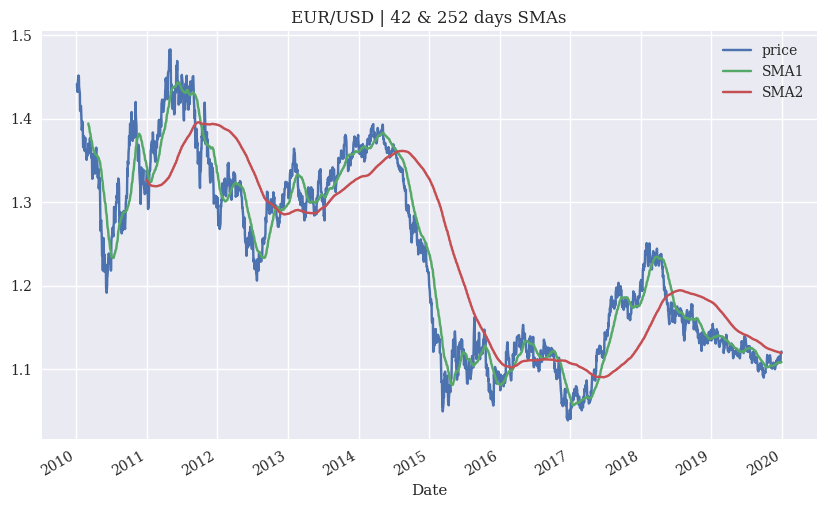

In [20]:
data.plot(title='EUR/USD | 42 & 252 days SMAs', figsize=(10, 6))

In [ ]:
# Rule is go LONG whenver shorter SMA is above longer one and SHORT longer SMA is below shorter one
# long = buy a share
# short = sell borrowed share

In [23]:
import numpy as np

<Axes: title={'center': 'Market Positioning'}, xlabel='Date'>

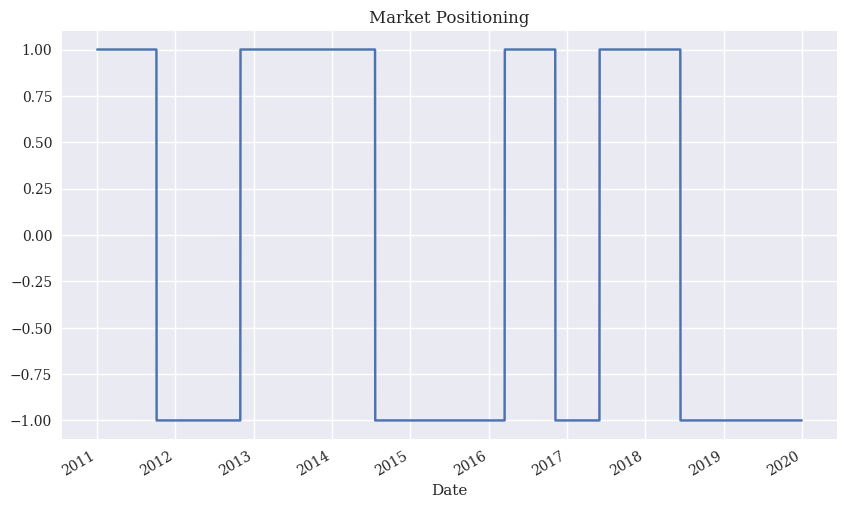

In [29]:
# Make graph indicating when to go long vs short
data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
data.dropna(inplace=True)
data['position'].plot(ylim=[-1.1, 1.1], title='Market Positioning', figsize=(10,6))

<Axes: >

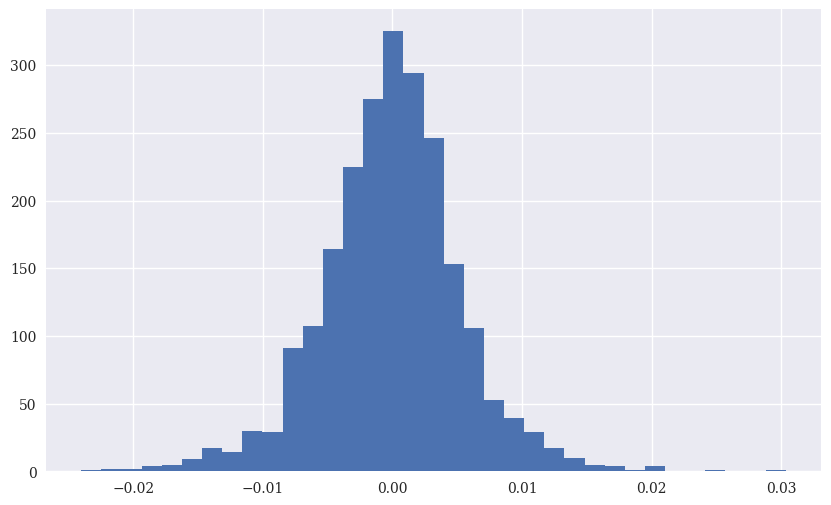

In [32]:
# Calculate log returns based on the original data day / day + 1
data['returns'] = np.log(data['price'] / data['price'].shift(1))
data['returns'].hist(bins=35, figsize=(10, 6))

In [35]:
# Calculate returns of the strategy over passive benchmark

# strategy = buy or sell on next day * diff in today to next day
# ie 
# if EUR/USD Day 1 is 1.10
# if EUR/USD Day 2 is 1.22
# SMA position of Day 2 is 1
# val = 1 * (1.1/1.22)

data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'strategy']].sum()

returns    -0.174785
strategy    0.255066
dtype: float64

In [39]:
# Calculate average performance using pandas and np

In [36]:
data[['returns', 'strategy']].mean() * 252

returns    -0.019463
strategy    0.028403
dtype: float64

In [38]:
np.exp(data[['returns', 'strategy']].mean() * 252) -1

returns    -0.019275
strategy    0.028811
dtype: float64

In [40]:
# Calculate standard deviations using pandas and numpy

In [41]:
data[['returns', 'strategy']].std() * 252 ** 0.5

returns     0.085431
strategy    0.085421
dtype: float64

In [42]:
(data[['returns', 'strategy']].apply(np.exp) -1).std() * 252 ** 0.5

returns     0.085421
strategy    0.085389
dtype: float64

In [ ]:
# other risk statistics include max drawdown and longest drawdown period
# MDD is a metric that measures the largest percentage decline in an investment's value from a peak to a trough over a specific period
# LDP is a metric that measures the longest decline in a strategy from pea to trough over a specefic period

<Axes: xlabel='Date'>

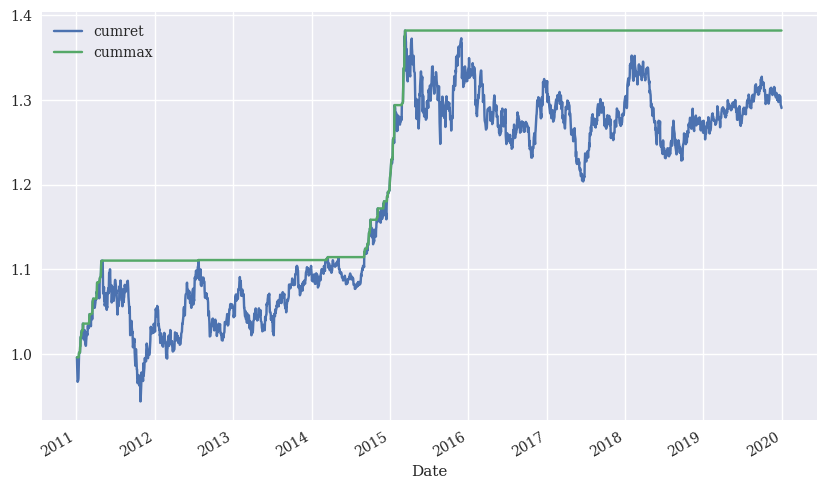

In [44]:
data['cumret'] = data['strategy'].cumsum().apply(np.exp)
data['cummax'] = data['cumret'].cummax()

data[['cumret', 'cummax']].dropna().plot(figsize=(10,6))

In [48]:
# MAX DRAW DOWN
drawdown = data['cummax'] - data['cumret']
drawdown.max()

np.float64(0.1781399095932965)

In [59]:
data.head()

,price,SMA1,SMA2,position,returns,strategy,cumret,cummax
Date,,,,,,,,
2011-01-03,1.3351,1.340945,1.325798,1,NaN,NaN,NaN,NaN
2011-01-04,1.3301,1.338940,1.325374,1,-0.003752,-0.003752,0.996255,0.996255
2011-01-05,1.3151,1.336448,1.324874,1,-0.011341,-0.011341,0.985020,0.996255
2011-01-06,1.3001,1.333995,1.324351,1,-0.011472,-0.011472,0.973785,0.996255
2011-01-07,1.2916,1.331602,1.323758,1,-0.006559,-0.006559,0.967418,0.996255


In [52]:
import datetime

In [56]:
# Longest Draw Down Period
temp = drawdown[drawdown == 0]
periods = (temp.index[1:].to_pydatetime() - temp.index[:-1].to_pydatetime())
periods

array([datetime.timedelta(days=9), datetime.timedelta(days=1),
       datetime.timedelta(days=4), datetime.timedelta(days=1),
       datetime.timedelta(days=1), datetime.timedelta(days=1),
       datetime.timedelta(days=3), datetime.timedelta(days=1),
       datetime.timedelta(days=1), datetime.timedelta(days=1),
       datetime.timedelta(days=5), datetime.timedelta(days=29),
       datetime.timedelta(days=1), datetime.timedelta(days=1),
       datetime.timedelta(days=10), datetime.timedelta(days=1),
       datetime.timedelta(days=2), datetime.timedelta(days=1),
       datetime.timedelta(days=3), datetime.timedelta(days=11),
       datetime.timedelta(days=5), datetime.timedelta(days=2),
       datetime.timedelta(days=6), datetime.timedelta(days=6),
       datetime.timedelta(days=1), datetime.timedelta(days=4),
       datetime.timedelta(days=1), datetime.timedelta(days=1),
       datetime.timedelta(days=1), datetime.timedelta(days=4),
       datetime.timedelta(days=1), datetime.timedelt

In [58]:
periods.max()

datetime.timedelta(days=596)